# 🧺 RFM Segmentation Analysis

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Simulate data from a master pool of customer ID's that is shared with the churn prediction repo:

In [15]:
# Shared code to generate master customer IDs
import numpy as np
import pandas as pd

np.random.seed(42)
n_customers = 1000  # total unique customers across both datasets

# Master customer ID pool
master_customer_ids = np.arange(1, n_customers + 1)

# Number of customers in RFM dataset (e.g., 800)
n_rfm_customers = 800

# Sample RFM customers (random without replacement)
rfm_customer_ids = np.random.choice(master_customer_ids, size=n_rfm_customers, replace=False)

# Simulate raw transaction data for these customers
# For demo: create 10 transactions per customer approx
transactions = []
for cust_id in rfm_customer_ids:
    n_orders = np.random.poisson(10) + 1
    for _ in range(n_orders):
        order_date = pd.Timestamp('2025-01-01') + pd.to_timedelta(np.random.randint(0, 365), unit='d')
        order_amount = np.round(np.random.exponential(100), 2)
        transactions.append([cust_id, order_date, order_amount])

df = pd.DataFrame(transactions, columns=['customer_id', 'order_date', 'order_amount'])
df.to_csv("../data/transactions.csv", index=False)
df.head()

,customer_id,order_date,order_amount
0,522,2025-04-11,0.27
1,522,2025-09-22,90.54
2,522,2025-02-07,53.08
3,522,2025-04-04,11.28
4,522,2025-03-10,177.56


## Step 1: Calculate RFM Metrics

In [16]:

snapshot_date = df['order_date'].max() + pd.Timedelta(days=1)
rfm = df.groupby('customer_id').agg({
    'order_date': lambda x: (snapshot_date - x.max()).days,
    'customer_id': 'count',
    'order_amount': 'sum'
}).rename(columns={
    'order_date': 'Recency',
    'customer_id': 'Frequency',
    'order_amount': 'Monetary'
})
rfm.head()
    

,Recency,Frequency,Monetary
customer_id,,,
1,106,6,595.85
3,163,7,1617.11
4,93,16,1209.94
6,33,11,1299.26
7,10,13,1098.63


## Step 2: Score & Segment Customers

In [17]:

rfm['R_quartile'] = pd.qcut(rfm['Recency'], 4, labels=[4,3,2,1])
rfm['F_quartile'] = pd.qcut(rfm['Frequency'].rank(method="first"), 4, labels=[1,2,3,4])
rfm['M_quartile'] = pd.qcut(rfm['Monetary'], 4, labels=[1,2,3,4])

rfm['RFM_Score'] = rfm['R_quartile'].astype(str) + rfm['F_quartile'].astype(str) + rfm['M_quartile'].astype(str)
rfm.head()
    

,Recency,Frequency,Monetary,R_quartile,F_quartile,M_quartile,RFM_Score
customer_id,,,,,,,
1,106,6,595.85,1,1,1,111
3,163,7,1617.11,1,1,4,114
4,93,16,1209.94,1,4,3,143
6,33,11,1299.26,2,2,3,223
7,10,13,1098.63,4,3,3,433


## Step 3: Visualize Segments

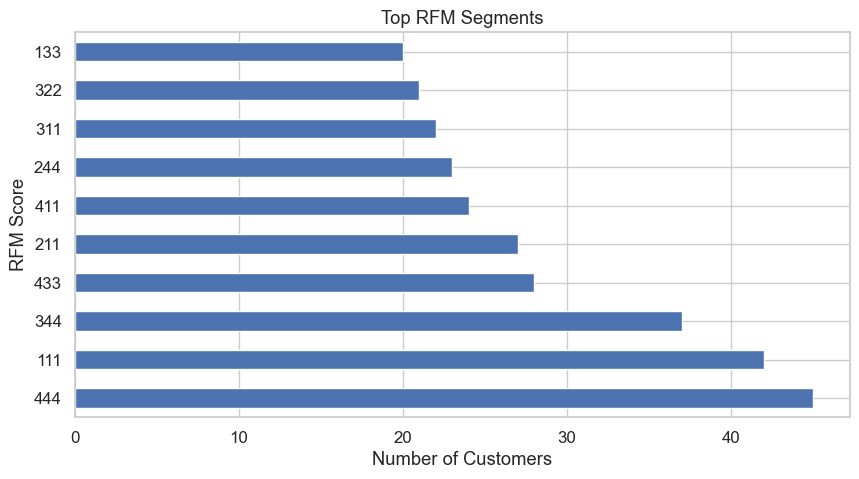

In [18]:

rfm['RFM_Score'].value_counts().head(10).plot(kind='barh', figsize=(10, 5))
plt.title("Top RFM Segments")
plt.xlabel("Number of Customers")
plt.ylabel("RFM Score")
plt.show()
    

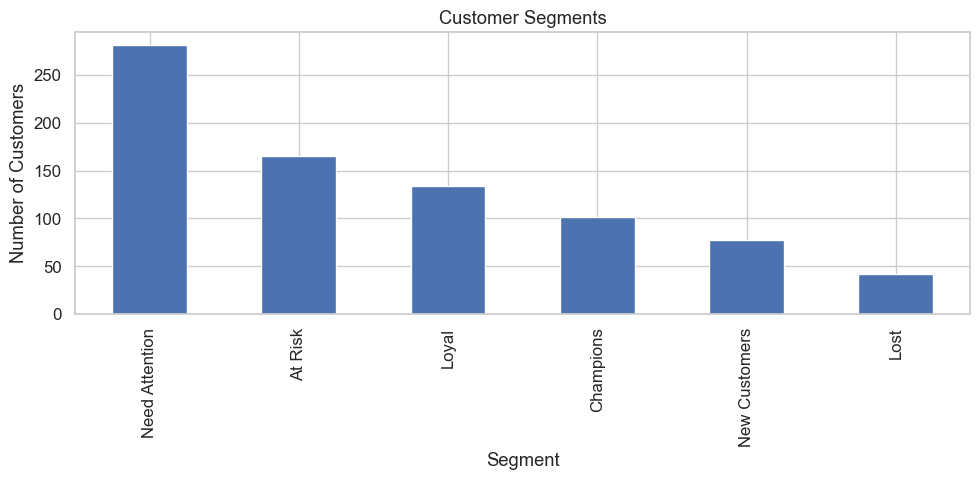

In [19]:
# Define a function to label segments
def segment_customer(row):
    r, f, m = int(row['R_quartile']), int(row['F_quartile']), int(row['M_quartile'])
    
    if r == 4 and f >= 3 and m >= 3:
        return "Champions"
    elif r >= 3 and f >= 3:
        return "Loyal"
    elif r == 4 and f <= 2:
        return "New Customers"
    elif r <= 2 and f >= 3:
        return "At Risk"
    elif r == 1 and f == 1 and m == 1:
        return "Lost"
    else:
        return "Need Attention"

# Apply the function
rfm['Segment'] = rfm.apply(segment_customer, axis=1)

# View segment distribution
rfm['Segment'].value_counts().plot(kind='bar', figsize=(10,5), title='Customer Segments')
plt.xlabel("Segment")
plt.ylabel("Number of Customers")
plt.tight_layout()
plt.show()


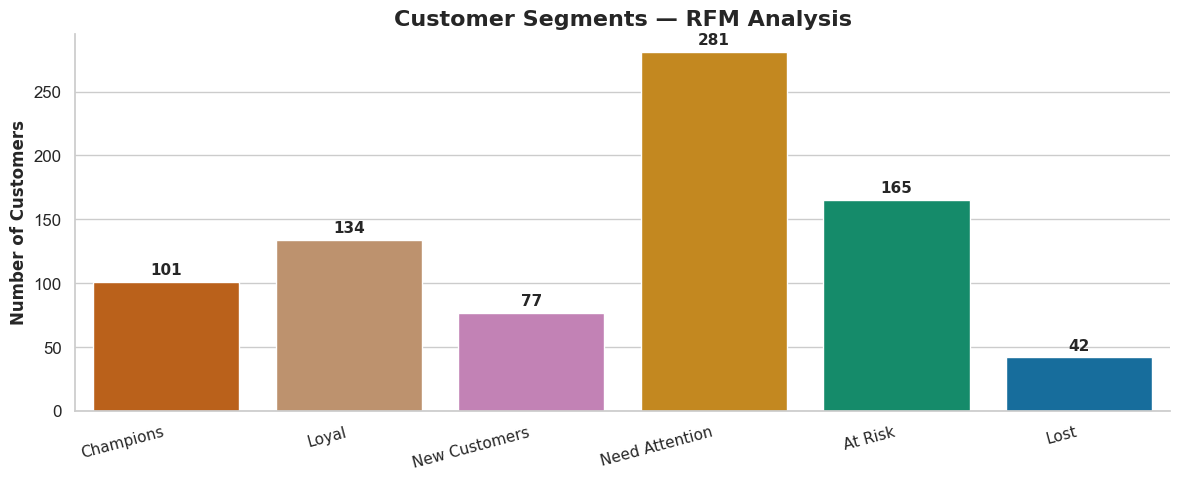

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'DejaVu Sans'

sns.set_theme(style="whitegrid", font_scale=1.1)

segment_order = ["Champions", "Loyal", "New Customers", "Need Attention", "At Risk", "Lost"]

plt.figure(figsize=(12, 5))
ax = sns.countplot(
    data=rfm,
    x="Segment",
    hue="Segment",
    order=segment_order,
    palette='colorblind',
    legend=False
)

for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', padding=3,
                 fontsize=11, fontweight='bold', fontfamily='DejaVu Sans')

plt.title("Customer Segments — RFM Analysis", fontsize=16, weight='bold', family='DejaVu Sans')
plt.xlabel("")
plt.ylabel("Number of Customers", fontsize=12, weight='bold', family='DejaVu Sans')
plt.xticks(rotation=15, ha="right", fontsize=11, family='DejaVu Sans')

sns.despine()
plt.tight_layout()

# Save as high-res PNG
plt.savefig("../assets/segment_distribution.png", dpi=300)

plt.show()

Export for dashboards:

In [21]:
rfm.rename(columns={
    "R_quartile": "R_score",
    "F_quartile": "F_score",
    "M_quartile": "M_score"
}, inplace=True)

In [22]:
# uncapitalize column names
rfm.columns = [col.lower() for col in rfm.columns]

In [23]:
# Turn customer_id back into a column for the export
rfm.reset_index(inplace=True)
# Export .csv for dashboards
rfm.to_csv("../output/rfm_segments.csv", index=False)